## Clustering and regression on clusters
The approach that we take in this section is to build a robust regression by mean of clustering. The process is start by applying a multi-cluster (number of cluster is quite large that we are sure that we passed the elbow criteria). Two different outcomes are expected:
1. There are few clusters that contain the majority of data.
2. Dataset is distributed among clusters almost uniformly.

If outcome 1 happens, the regression model of interest will be trained on the sorted clusters based on their population from large to small. The test error will be measured every time a new cluster is added to the training dataset. The accumulated clusters with minimum generalization error will be used as the final trained model.

If the scenario 2 happens, then there would be no preferance among the clusters. The best course of action would be similar to *cross validation* by taking one cluster of data out and train on the rests. The best model can be picked either by taking average (need to be spicific, if it is a decision tree based model the average of models does not mean anything), or exclude one cluster that when it is added to the training dataset increase the generalization error dramaticly.

### Form of outliers and distibution of data points


### Steps:
- [ ] Generate some dataset.
- [ ] Add a uniform noise to original data.
- [ ] Build a simple regression model
- [ ] Apply idea of multiple cluster clustering.
- [ ] Train the same model on clusters accumulatively.

### Two Scenario
Here we identify two specific forms of outliers:
1. Outliers are uniformly distributated in range of inliers
2. Outliers are isolated in the feature space

Discuss the *isolation* of outliers and *curse of dimensionality*

## Generating data with outliers
In this example outliers are completely isolated from the inliers.

In [1]:
import numpy as np
import numpy.random as rnd
import pandas as pd
import matplotlib.pyplot as pl
# to pairplot
import seaborn as sns
# to generate random dataset (+outliers)
from sklearn.datasets import make_blobs, make_moons


In [2]:
rnd.seed(47)

In [3]:
# parameters 
size_data = 500
ratio_outliers = 0.1
size_outliers = int(ratio_outliers*size_data)
size_inliers = size_data - size_outliers

# Generate one cluster of data for inliers
X_in, _ = make_blobs(n_samples=size_inliers, n_features=2, centers=1)
a1 = 1.2
a2 = 2.1
# target: linear function of features
y_in = a1*X_in[:,0] + a2*X_in[:,1] + rnd.rand(size_inliers)


In [4]:
# outliers
X_out, _ = make_blobs(n_samples=size_outliers, n_features=2, centers=1)
a1 = 1.2
a2 = 2.1
# target: just a random noise in the same range of inlier data
y_out = (y_in.max() - y_in.min()) * rnd.rand(size_outliers) 

### Concatonate `inliers` and `outliers`

In [5]:
X = np.r_[X_in, X_out]
y = np.r_[y_in, y_out]

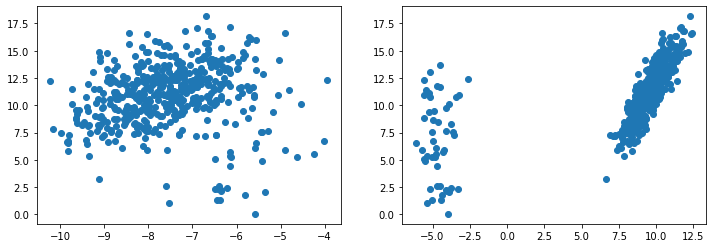

In [6]:
fig, ax = pl.subplots(1,2, figsize=(12,4))
ax[0].scatter(X[:,0], y)
ax[1].scatter(X[:,1], y)


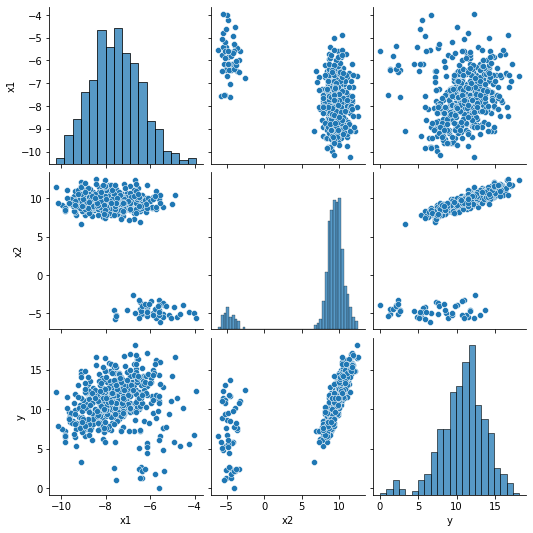

In [7]:
data = pd.DataFrame(np.c_[X,y], columns=['x1', 'x2','y'])
sns.pairplot(data)

## Training a model

### Without outlier treatment

In [8]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error as mae

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [10]:
lr = LinearRegression()

In [11]:
lr.fit(X_train, y_train)

y_pred_train = lr.predict(X_train)
y_pred_test = lr.predict(X_test)

In [12]:
train_mae = mae(y_train, y_pred_train)
test_mae = mae(y_test, y_pred_test)


In [13]:
print("train MAE: {:.3} and test MAE: {:.3}".format(train_mae, test_mae))

train MAE: 1.37 and test MAE: 1.56


## With outlier treatmet
- What is the best performance that one get if we remove outliers completely?

In [14]:
# make a train-test on inliers
X_train, X_test, y_train, y_test = train_test_split(X_in, y_in, test_size=0.33, random_state=42)

In [15]:
lr.fit(X_train, y_train)

y_pred_train = lr.predict(X_train)
y_pred_test = lr.predict(X_test)

train_mae = mae(y_train, y_pred_train)
test_mae = mae(y_test, y_pred_test)


In [16]:
train_mae, test_mae

(0.23413505863731154, 0.23058964826011424)

### Clustering with large number of clusters
- [ ] Apply clustering, make sure you pass elbow criteria.
- [ ] Sort cluster based on their population.
- [ ] Start training from high population accumulatively.
- [ ] Measure generalization error.
- [ ] Plot error agains clusters.

In [17]:
from sklearn.cluster import KMeans

In [18]:
km = KMeans(n_clusters = 10)

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [20]:
km.fit(X_train)

KMeans(n_clusters=10)

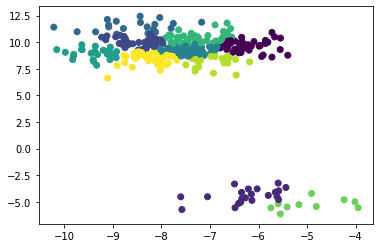

In [21]:
pl.scatter(X_train[:,0], X_train[:,1], c = km.labels_)

#### Population of clusters

In [22]:
cluster_populations = {i:km.labels_[km.labels_ == i].size for i in range(0,10)}

In [23]:
# sort cluster based on their population
cluster_sorted_key = [c[0] for c in sorted(cluster_populations.items(), key=lambda el: el[1], reverse=True)]

In [24]:
cluster_sorted_key

[4, 6, 9, 2, 0, 5, 8, 1, 3, 7]

In [25]:
X_cum = X_train[km.labels_ == cluster_sorted_key[0]]
y_cum = y_train[km.labels_ == cluster_sorted_key[0]]
for cl in cluster_sorted_key[1:]:
    lr.fit(X_cum, y_cum)
    print("Score: {:.3}".format(lr.score(X_test, y_test)))
    X_cum = np.r_[X_cum, X_train[km.labels_ == cluster_sorted_key[cl]]]
    y_cum = np.r_[y_cum, y_train[km.labels_ == cluster_sorted_key[cl]]]

Score: -5.57
Score: -5.59
Score: 0.348
Score: 0.322
Score: 0.374
Score: 0.405
Score: 0.484
Score: 0.483
Score: 0.494


The way that we measure the performance is not fair.  Either remove outliers and them train/test split or do not compare the result against purely from `inliers`.


In [26]:
def cluster_regression(X, y):
    """ Performs clustering on dataset. Learn a regression model over clusters accumulatively.
    
    input:
    ------
    X: np.array, design matrix
    y: np.array, target vector (labels)
    
    output:
    -------
    model: sklearn trained model, best model
    """
    # TODO: 
    # - right way to decide the number of clusters
    # - devide to validation, test, cross validation 
    # ...
    
    # train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                        test_size=0.33, 
                                                        random_state=42)

    # Clustering
    n_clusters = 10
    km = KMeans(n_clusters = n_clusters)
    km.fit(X_train)
    # calculate population of clusters
    cluster_populations = {i:km.labels_[km.labels_ == i].size 
                           for i in range(0,n_clusters)}
    
    # sort cluster based on their population
    cluster_sorted_key = [c[0] for c in sorted(cluster_populations.items(), 
                                               key=lambda el: el[1], 
                                               reverse=True)]
    # Regression
    X_cum = X_train[km.labels_ == cluster_sorted_key[0]]
    y_cum = y_train[km.labels_ == cluster_sorted_key[0]]
    for cl in cluster_sorted_key[1:]:
        lr.fit(X_cum, y_cum)
        print("Score: {:.3}".format(lr.score(X_test, y_test)))
        X_cum = np.r_[X_cum, X_train[km.labels_ == cluster_sorted_key[cl]]]
        y_cum = np.r_[y_cum, y_train[km.labels_ == cluster_sorted_key[cl]]]

In [27]:
cluster_regression(X,y)

Score: -5.91
Score: -6.51
Score: 0.449
Score: 0.521
Score: 0.479
Score: 0.475
Score: 0.518
Score: 0.527
Score: 0.529


In [28]:
import sys  
sys.path.insert(0, '/Users/cm-amin/projects/outlier_handling/')
from src.cluster_regression import cluster_regression

In [29]:
cluster_regression(X,y)

Score: -6.27
Score: -7.13
Score: -7.04
Score: -6.78
Score: -6.46
Score: -6.46
Score: 0.536
Score: 0.526
Score: 0.522
